In [1]:
import sklearn
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from tqdm.auto import tqdm

# Part 1.1 - Setup

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
train_data = trainset.data / 255
train_labels = np.array(trainset.targets)
test_data = testset.data / 255
test_labels = np.array(testset.targets)

train_indices = np.random.choice(np.arange(50000), size=5000, replace=False)
test_indices = np.random.choice(np.arange(10000), size=1000, replace=False)

In [4]:
train_data = train_data[train_indices]
train_labels = train_labels[train_indices]
test_data = test_data[test_indices]
test_labels = test_labels[test_indices]

# Part 1.2 - SVM

In [ ]:
lin_SVM = SVC(kernel='linear')
lin_SVM.fit(train_data.reshape(5000, -1), train_labels)

SVC(kernel='linear')

In [ ]:
lin_pred_labels_test = lin_SVM.predict(test_data.reshape(1000, -1))

In [ ]:
lin_mistakes_test = np.array([int(lin_pred_labels_test[i] == test_labels[i]) for i in range(1000)])
lin_acc_test = np.sum(lin_mistakes_test) / 1000
print(f"Test accuracy of linear SVM: {lin_acc_test}")

Test accuracy of linear SVM: 0.308


In [ ]:
lin_pred_labels_train = lin_SVM.predict(train_data.reshape(5000, -1))
lin_mistakes_train = np.array([int(lin_pred_labels_train[i] == train_labels[i]) for i in range(5000)])
lin_acc_train = np.sum(lin_mistakes_train) / 5000
print(f"Train accuracy of linear SVM: {lin_acc_train}")

In [ ]:
RBF_SVM = SVC(kernel='rbf')
RBF_SVM.fit(train_data.reshape(5000, -1), train_labels)

In [ ]:
rbf_pred_labels_test = RBF_SVM.predict(test_data.reshape(1000, -1))
rbf_mistakes_test = np.array([int(rbf_pred_labels_test[i] == test_labels[i]) for i in range(1000)])
rbf_acc_test = np.sum(rbf_mistakes_test) / 1000
print(f"Test accuracy of RBF SVM: {rbf_acc_test}")

In [ ]:
rbf_pred_labels_train = RBF_SVM.predict(train_data.reshape(5000, -1))
rbf_mistakes_train = np.array([int(rbf_pred_labels_train[i] == train_labels[i]) for i in range(5000)])
rbf_acc_train = np.sum(rbf_mistakes_train) / 5000
print(f"Train accuracy of RBF SVM: {rbf_acc_train}")

# Part 2.1 - Baseline model

In [5]:
B = 64
num_epochs = 20

class BaseLineNN(nn.Module):
    def __init__(self, std, width, xavier_init=False):
        super().__init__()
        
        self.fc1 = nn.Linear(32*32*3, width)
        W1 = torch.normal(0.0, std, size=(32*32*3, width)).type(torch.double)
        W2 = torch.normal(0.0, std, size=(width, 10)).type(torch.double)
        if xavier_init:
          nn.init.xavier_normal_(W1)
          nn.init.xavier_normal_(W2)
        self.fc1.weight = nn.Parameter(W1)
        self.fc2 = nn.Linear(width, 10)
        self.fc2.weight = nn.Parameter(W2)
        
    def forward(self, x):
        x = x @ self.fc1.weight
        x = F.relu(x)
        x = x @ self.fc2.weight
        return x

In [7]:
def calc_acc_one_hot(target, pred):
  correct = [target[i][torch.argmax(pred[i])] for i in range(target.shape[0])]
  return sum(correct) / len(correct)

In [124]:
def calc_acc_labels(target, probs):
  # print(f"shape of target: {target.shape}")
  # print(f"shape of probes: {probs.shape}")
  preds = torch.argmax(probs, dim=1)
  # print(f"shape of preds: {preds.shape}")
  correct = (target == preds)
  # print(f"shape of correct: {correct.shape}")
  return (torch.sum(correct) / correct.shape[0])

In [116]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss()

m_vals = torch.tensor([i/10 for i in range(6,10)])
lr_vals = torch.tensor([i/1000 for i in range(2,6)])
std_vals = torch.tensor([0.05, 0.1, 0.5])


train_data_flat = torch.from_numpy(train_data.reshape(5000, -1))
test_data_flat = torch.from_numpy(test_data.reshape(1000, -1))

train_labels_cuda = torch.from_numpy(train_labels).to(device)
test_labels_cuda = torch.from_numpy(test_labels).to(device)
test_target_cuda = torch.zeros(1000, 10).to(device)
for i in range(1000):
  test_target_cuda[i][test_labels_cuda[i]] = 1

train_data_flat = train_data_flat.to(device)
test_data_flat = test_data_flat.to(device)

In [120]:
def model_epoch(model, optim, ret_test_acc=False, ret_train_acc=False, ret_test_loss=False):
  # model.train()
  ind_shuff = np.arange(5000)
  np.random.shuffle(ind_shuff)
  ind_shuff = torch.from_numpy(ind_shuff)
  train_loss_sum = 0
  train_acc = 0
  test_acc = 0
  test_loss = 0
  for i in range(0,4929, B):
    inds = ind_shuff[i: i+B]
    input = train_data_flat[inds]
    input.type(dtype = torch.double)
    target = torch.zeros(B,10).to(device)
    for s in range(B):
      target[s][train_labels_cuda[inds[s]]] = 1
    optim.zero_grad()
    output = model(input)
    train_loss = loss_fn(output, target)
    train_loss_sum += train_loss.item()
    train_loss.backward()
    optim.step()
  if ret_test_loss or ret_test_acc:
    # model.eval()
    test_pred = model(test_data_flat)
  if ret_test_loss:
    test_loss = loss_fn(test_pred, test_target_cuda).item()
  if ret_train_acc:
    train_acc = calc_acc_labels(train_labels_cuda[inds], output) 
  if ret_test_acc:
    test_acc = calc_acc_labels(test_labels_cuda, test_pred)
  return train_loss_sum / (i/64 + 1), test_loss, train_acc, test_acc


In [ ]:
best_acc = 0
best_hp = (0, 0, 0)

for i in tqdm(range(len(m_vals))):
  for j in tqdm(range(len(lr_vals))):
    for k in tqdm(range(len(std_vals))):
      model = BaseLineNN(std_vals[k], 256)
      model.to(device)
      optimizer = optim.SGD(model.parameters(), lr=lr_vals[j], momentum=m_vals[i])
      for e in range(num_epochs):
        train_loss, test_loss, train_acc, test_acc = model_epoch(model, optimizer, ret_test_acc=True)
        if test_acc > best_acc:
          best_acc = test_acc
          best_hp = (m_vals[i], lr_vals[j], std_vals[k])

In [44]:
best_momentum = round(float(best_hp[0]), 4)
best_lr = round(float(best_hp[1]),4)
best_std = round(float(best_hp[2]),4)
print(f"Best hyperparameters were: momentum={best_momentum}, lr={best_lr}, std={best_std}")
print(f"Best test accuracy achieved: {round(float(best_acc),4)}")

Best hyperparameters were: momentum=0.9, lr=0.003, std=0.05
Best test accuracy achieved: 0.404


In [83]:
# now we train a model with the best hyperparameters
num_epochs = 50

test_loss_best_baseline = torch.zeros(num_epochs).to(device)
test_acc_best_baseline = torch.zeros(num_epochs).to(device)
train_loss_best_baseline = torch.zeros(num_epochs).to(device)
train_acc_best_baseline = torch.zeros(num_epochs).to(device)

def test_optimizer(opt_name):
  model = BaseLineNN(best_std, 256)
  model.to(device)
  if opt_name == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
  else:
    optimizer = optim.Adam(model.parameters(), lr=best_lr)
  for e in tqdm(range(num_epochs)):
    train_loss, test_loss, train_acc, test_acc = model_epoch(model, optimizer,
                                                             ret_test_acc=True, 
                                                             ret_train_acc=True, 
                                                             ret_test_loss=True)
    test_loss_best_baseline[e] = test_loss
    test_acc_best_baseline[e] = test_acc
    train_loss_best_baseline[e] = train_loss
    train_acc_best_baseline[e] = train_acc

In [125]:
test_optimizer("sgd")

  0%|          | 0/50 [00:00<?, ?it/s]

In [126]:
def plot_acc(test_acc, train_acc, num_epochs):
  plt.plot(range(1,num_epochs+1), test_acc.cpu().detach().numpy(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_acc.cpu().detach().numpy(), label = "Train")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.title("Accuracy of model over time")
  plt.xticks(range(0,num_epochs+1,5))
  plt.legend()
  plt.show()

def plot_loss(test_loss, train_loss, num_epochs):
  plt.plot(range(1,num_epochs+1), test_loss.cpu().detach().numpy(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_loss.cpu().detach().numpy(), label = "Train")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.title("Loss of model over time")
  plt.xticks(range(0,num_epochs+1,5))
  plt.legend()
  plt.show()

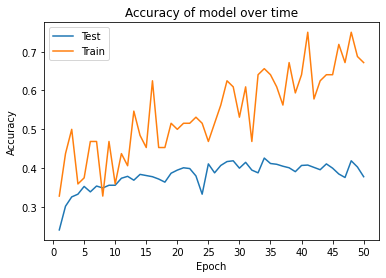

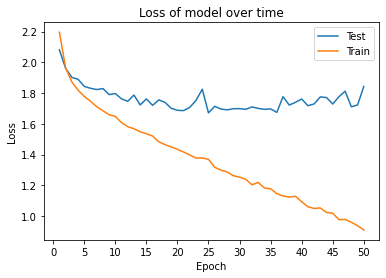

In [127]:
plot_acc(test_acc_best_baseline, train_acc_best_baseline, num_epochs)
plot_loss(test_loss_best_baseline, train_loss_best_baseline, num_epochs)

# Part 2.2 - Optimization

In [128]:
test_optimizer("adam")

  0%|          | 0/50 [00:00<?, ?it/s]

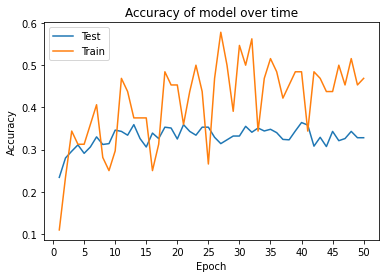

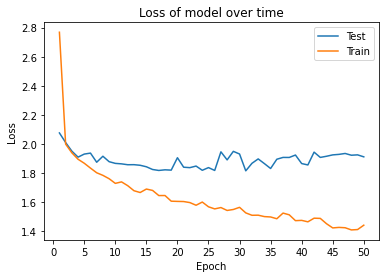

In [129]:
plot_acc(test_acc_best_baseline, train_acc_best_baseline, num_epochs)
plot_loss(test_loss_best_baseline, train_loss_best_baseline, num_epochs)

Model with Adam optimizer converges a lot quicker, but achieves worse accuracy and loss, on both train and test.

# Part 2.3 - Initialization

In [130]:
model = BaseLineNN(best_std, 256, xavier_init=True)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
for e in tqdm(range(num_epochs)):
  train_loss, test_loss, train_acc, test_acc = model_epoch(model, optimizer,
                                                             ret_test_acc=True, 
                                                             ret_train_acc=True, 
                                                             ret_test_loss=True)
  test_loss_best_baseline[e] = test_loss
  test_acc_best_baseline[e] = test_acc
  train_loss_best_baseline[e] = train_loss
  train_acc_best_baseline[e] = train_acc

  0%|          | 0/50 [00:00<?, ?it/s]

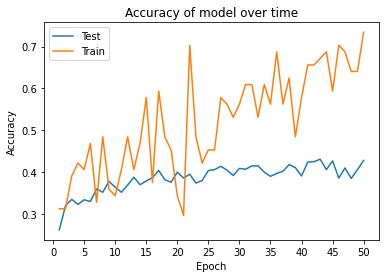

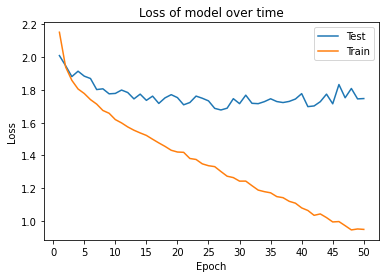

In [131]:
plot_acc(test_acc_best_baseline, train_acc_best_baseline, num_epochs)
plot_loss(test_loss_best_baseline, train_loss_best_baseline, num_epochs)

Model seems to achieve slightly better loss and accuracy, but the difference isn't significant.

# Part 2.4 - Regularization

In [132]:
decay_vals = [i / 10 for i in range(1,5)]

test_loss_reg = torch.zeros(len(decay_vals), num_epochs).to(device)
test_acc_reg = torch.zeros(len(decay_vals), num_epochs).to(device)
train_loss_reg = torch.zeros(len(decay_vals), num_epochs).to(device)
train_acc_reg = torch.zeros(len(decay_vals), num_epochs).to(device)


for i in tqdm(range(len(decay_vals))):
  model = BaseLineNN(best_std, 256, xavier_init=True)
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum,
                        weight_decay = decay_vals[i])
  for e in tqdm(range(num_epochs)):
    train_loss, test_loss, train_acc, test_acc = model_epoch(model, optimizer,
                                                              ret_test_acc=True, 
                                                              ret_train_acc=True, 
                                                              ret_test_loss=True)
    test_loss_reg[i][e] = test_loss
    test_acc_reg[i][e] = test_acc
    train_loss_reg[i][e] = train_loss
    train_acc_reg[i][e] = train_acc

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

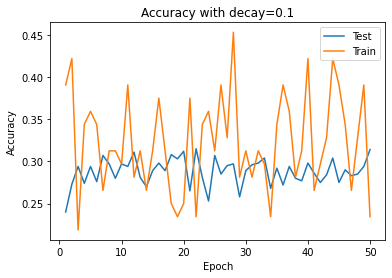

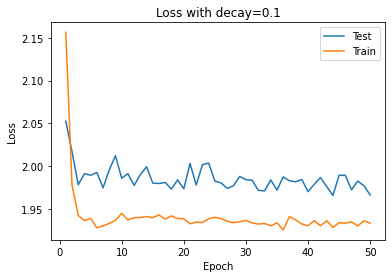

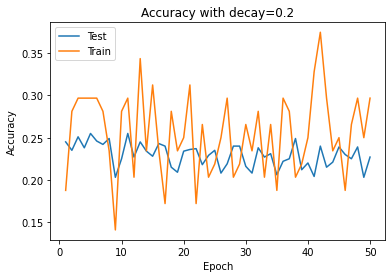

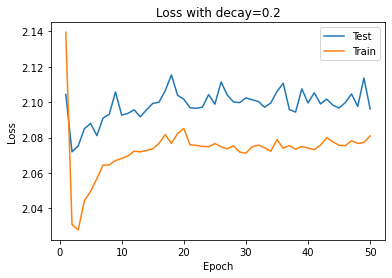

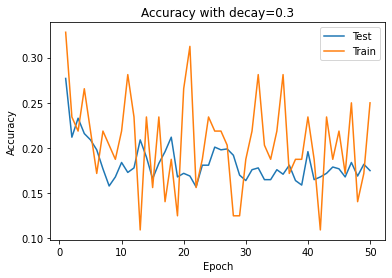

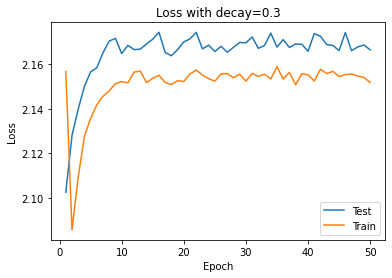

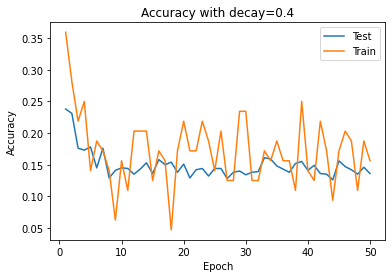

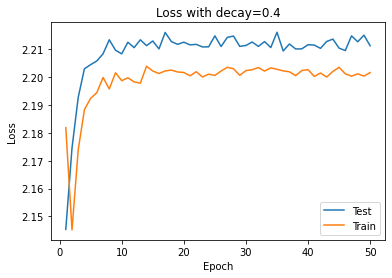

In [133]:
for i in range(len(decay_vals)):
  plt.plot(range(1,num_epochs+1), test_acc_reg[i].cpu(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_acc_reg[i].cpu(), label = "Train")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.title(f"Accuracy with decay={decay_vals[i]}")
  plt.legend()
  plt.show()

  plt.plot(range(1,num_epochs+1), test_loss_reg[i].cpu().detach(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_loss_reg[i].cpu().detach(), label = "Train")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.title(f"Loss with decay={decay_vals[i]}")
  plt.legend()
  plt.show()

Weight decay seemed to hurt both loss and accuracy, for both training and test.

In [134]:
drop_vals = [i/10 for i in range(1,6)]

test_loss_drop = torch.zeros(len(drop_vals), num_epochs).to(device)
test_acc_drop = torch.zeros(len(drop_vals), num_epochs).to(device)
train_loss_drop = torch.zeros(len(drop_vals), num_epochs).to(device)
train_acc_drop = torch.zeros(len(drop_vals), num_epochs).to(device)

class DropNN(BaseLineNN):
    def __init__(self, std, width, p, xavier_init=False):
        super().__init__(std, width)
        
        self.dropout = nn.Dropout(p)
        
    def forward(self, x):
        x = x @ self.fc1.weight
        x = self.dropout(x)
        x = F.relu(x)
        x = x @ self.fc2.weight
        return x

In [135]:
for i in tqdm(range(len(drop_vals))):
  model = DropNN(best_std, 256, drop_vals[i], xavier_init=True)
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
  for e in tqdm(range(num_epochs)):
    train_loss, test_loss, train_acc, test_acc = model_epoch(model, optimizer,
                                                              ret_test_acc=True, 
                                                              ret_train_acc=True, 
                                                              ret_test_loss=True)
    test_loss_drop[i][e] = test_loss
    test_acc_drop[i][e] = test_acc
    train_loss_drop[i][e] = train_loss
    train_acc_drop[i][e] = train_acc

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

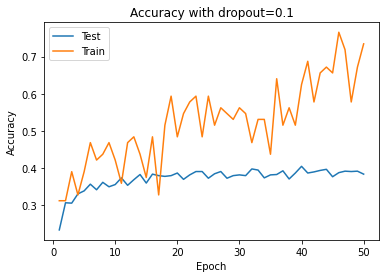

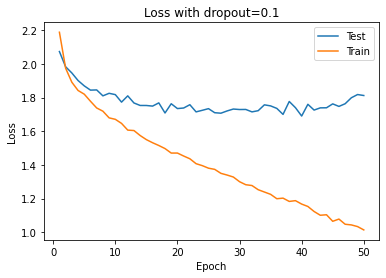

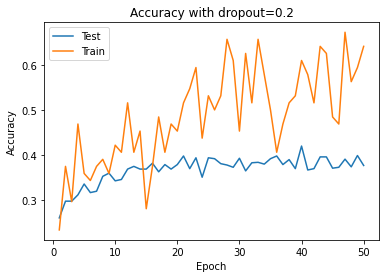

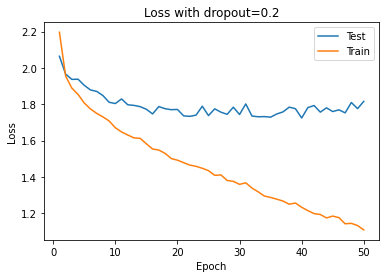

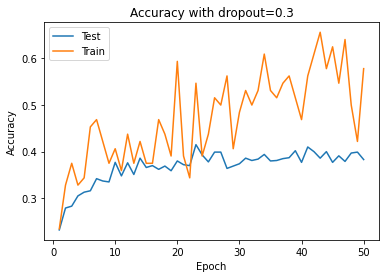

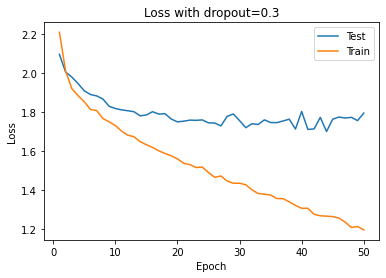

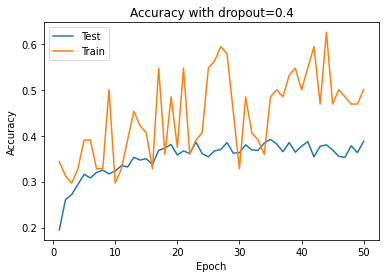

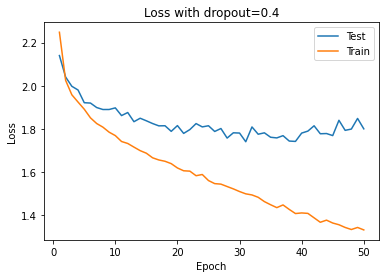

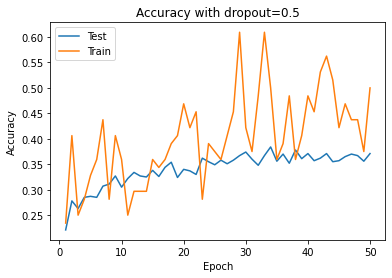

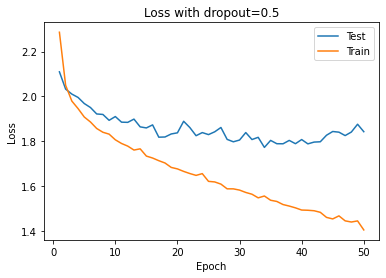

In [136]:
for i in range(len(drop_vals)):
  plt.plot(range(1,num_epochs+1), test_acc_drop[i].cpu(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_acc_drop[i].cpu(), label = "Train")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.title(f"Accuracy with dropout={drop_vals[i]}")
  plt.legend()
  plt.show()

  plt.plot(range(1,num_epochs+1), test_loss_drop[i].cpu().detach(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_loss_drop[i].cpu().detach(), label = "Train")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.title(f"Loss with dropout={drop_vals[i]}")
  plt.legend()
  plt.show()

Not sure what the effect is.

# Part 2.5 - Preprocessing

In [99]:
from sklearn.decomposition import PCA

In [137]:
test_loss_pca = torch.zeros(num_epochs).to(device)
test_acc_pca = torch.zeros(num_epochs).to(device)
train_loss_pca = torch.zeros(num_epochs).to(device)
train_acc_pca = torch.zeros(num_epochs).to(device)

class PCANN(nn.Module):
    def __init__(self, std, width, pca_dim):
        super().__init__()
        
        self.pca = PCA(n_components=pca_dim)
        self.pca.fit(train_data.reshape(5000, -1))
        self.fc1 = nn.Linear(pca_dim, width)
        W1 = torch.normal(0.0, std, size=(pca_dim, width)).type(torch.double)
        W2 = torch.normal(0.0, std, size=(width, 10)).type(torch.double)
        self.fc1.weight = nn.Parameter(W1)
        self.fc2 = nn.Linear(width, 10)
        self.fc2.weight = nn.Parameter(W2)
        
    def forward(self, x):
        x = torch.tensor(self.pca.transform(x.cpu())).to(device)
        x = x @ self.fc1.weight
        x = F.relu(x)
        x = x @ self.fc2.weight
        return x

In [138]:
model = PCANN(best_std, 256, 100)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
for e in tqdm(range(num_epochs)):
  train_loss, test_loss, train_acc, test_acc = model_epoch(model, optimizer,
                                                              ret_test_acc=True, 
                                                              ret_train_acc=True, 
                                                              ret_test_loss=True)
  test_loss_pca[e] = test_loss
  test_acc_pca[e] = test_acc
  train_loss_pca[e] = train_loss
  train_acc_pca[e] = train_acc

  0%|          | 0/50 [00:00<?, ?it/s]

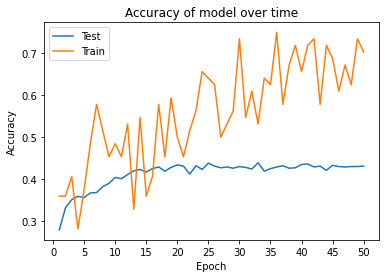

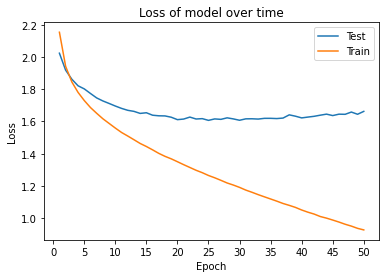

In [139]:
plot_acc(test_acc_pca, train_acc_pca, num_epochs)
plot_loss(test_loss_pca, train_loss_pca, num_epochs)

Preproccessing doesn't seem to effect accuracy at all, change in loss seems smoother.

# Part 2.6 - Network Width

In [140]:
width_vals = [6, 10, 12]

test_loss_wide = torch.zeros(3, num_epochs).to(device)
test_acc_wide = torch.zeros(3, num_epochs).to(device)
train_loss_wide = torch.zeros(3, num_epochs).to(device)
train_acc_wide = torch.zeros(3, num_epochs).to(device)

In [141]:
for i in tqdm(range(3)):
  model = BaseLineNN(best_std, 2**width_vals[i])
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
  for e in tqdm(range(num_epochs)):
    train_loss, test_loss, train_acc, test_acc = model_epoch(model, optimizer,
                                                              ret_test_acc=True, 
                                                              ret_train_acc=True, 
                                                              ret_test_loss=True)
    test_loss_wide[i][e] = test_loss
    test_acc_wide[i][e] = test_acc
    train_loss_wide[i][e] = train_loss
    train_acc_wide[i][e] = train_acc

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

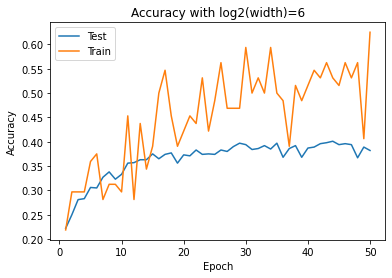

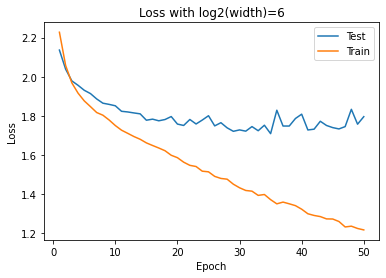

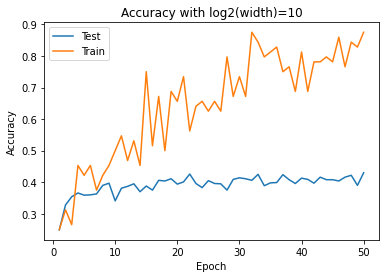

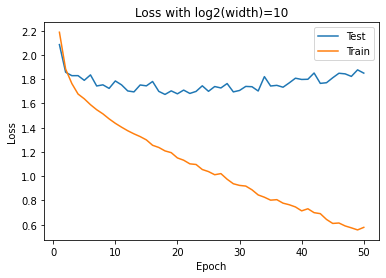

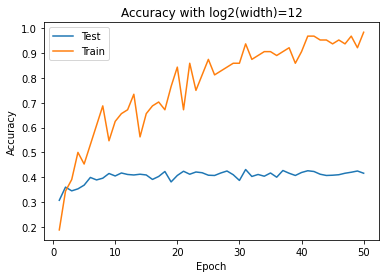

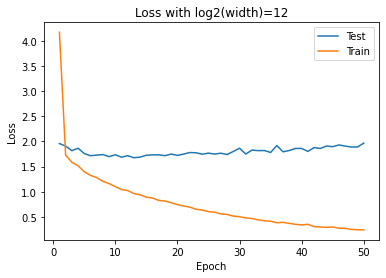

In [142]:
for i in range(3):
  plt.plot(range(1,num_epochs+1), test_acc_wide[i].cpu(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_acc_wide[i].cpu(), label = "Train")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.title(f"Accuracy with log2(width)={width_vals[i]}")
  plt.legend()
  plt.show()

  plt.plot(range(1,num_epochs+1), test_loss_wide[i].detach().cpu(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_loss_wide[i].detach().cpu(), label = "Train")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.title(f"Loss with log2(width)={width_vals[i]}")
  plt.legend()
  plt.show()

While wider nets achieve better loss and accuracy on training set, the loss and accuracy on test set don't change much.

# Part 2.7 - Network Depth

In [111]:
class DeepNN(nn.Module):
    def __init__(self, std, width, depth):
        super().__init__()
        self.depth = depth-1
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(32*32*3, width))
        W = torch.normal(0.0, std, size=(32*32*3, width)).type(torch.double)
        self.layers[0].weight = nn.Parameter(W)

        for i in range(1, self.depth-1):
          self.layers.append(nn.Linear(width, width))
          W = torch.normal(0.0, std, size=(width, width)).type(torch.double)
          self.layers[i].weight = nn.Parameter(W)
        
        self.layers.append(nn.Linear(width, 10))
        W = torch.normal(0.0, std, size=(width, 10)).type(torch.double)
        self.layers[-1].weight = nn.Parameter(W)
        
    def forward(self, x):
        for i in range(self.depth-1):
          x = x @ self.layers[i].weight
          x = F.relu(x)

        x = x @ self.layers[self.depth-1].weight
        return x

In [143]:
depth_vals = [3, 4, 10]

test_loss_deep = torch.zeros(3, num_epochs).to(device)
test_acc_deep = torch.zeros(3, num_epochs).to(device)
train_loss_deep = torch.zeros(3, num_epochs).to(device)
train_acc_deep = torch.zeros(3, num_epochs).to(device)

In [144]:
for i in tqdm(range(3)):
  model = DeepNN(best_std, 64, depth_vals[i])
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
  for e in tqdm(range(num_epochs)):
    train_loss, test_loss, train_acc, test_acc = model_epoch(model, optimizer,
                                                              ret_test_acc=True, 
                                                              ret_train_acc=True, 
                                                              ret_test_loss=True)
    test_loss_deep[i][e] = test_loss
    test_acc_deep[i][e] = test_acc
    train_loss_deep[i][e] = train_loss
    train_acc_deep[i][e] = train_acc

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

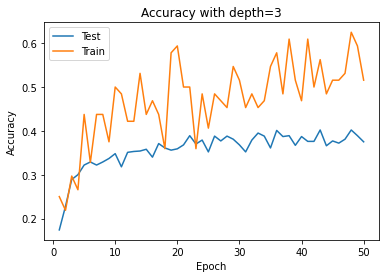

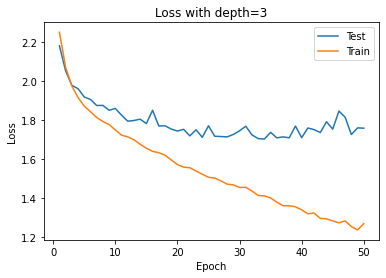

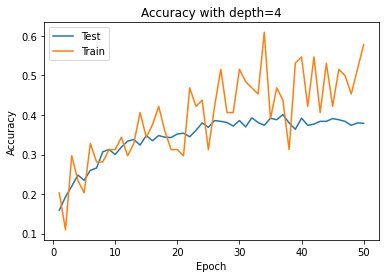

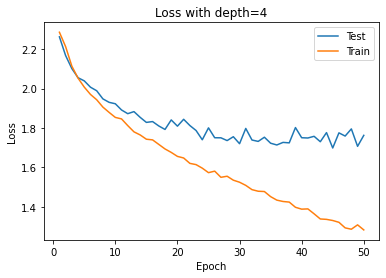

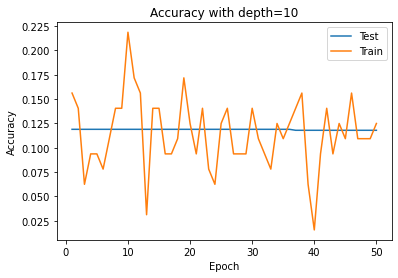

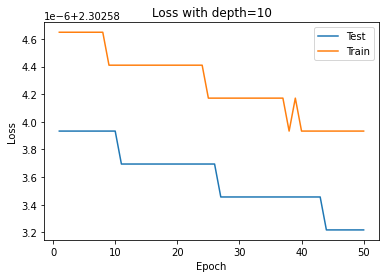

In [145]:
for i in range(3):
  plt.plot(range(1,num_epochs+1), test_acc_deep[i].cpu(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_acc_deep[i].cpu(), label = "Train")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.title(f"Accuracy with depth={depth_vals[i]}")
  plt.legend()
  plt.show()

  plt.plot(range(1,num_epochs+1), test_loss_deep[i].detach().cpu(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_loss_deep[i].detach().cpu(), label = "Train")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.title(f"Loss with depth={depth_vals[i]}")
  plt.legend()
  plt.show()